
TFG

Este es el codigo del tfg de Borja Jimeno

En esta primera celda vamos a definir todas las funciones y variables que necesitaremos para calcular el ritmo teórico. Cada función está explicada al inicio y cada variable tiene asociadas sus unidades en un comentario a la derecha.  

Para la realización de las funciones se ha tomado como referencia:  
-El pdf ('rateTutorial_MMartinez_TAE25.pdf)    
-El capítulo 7 de la Tesis de María ('tesisMaria_chap7.pdf')   
-El artículo 'Inelastic and Elastic Scattering of 187-Mev Electrons from Selected Even-Even Nuclei - Richard Helm - PHISICAL REVIEW VOLUME 104, NUMBER 5 DECEMBER 1, 1956'  
-Para calcular el Quenching Factor, Sección 4.3.2 de la tesis de Tamara Pardo Yanguas ('Tesis-Tamara.pdf')

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm

from funciones_ritmo_teorico import*
from funciones_ritmo_exp import*


plt.rcParams['font.size'] = 18


## Plots de exclusion

Para dibujar los plots de exlusion necesitamos obtener la funcion $\sigma_{si}(m_{\chi})$ que nos da los valores de la seccion eficaz para la que, dada una masa del WIMP (GeV), el numero de cuentas teorico coincide con el numero de cuentas experimental. Recordando las expresiones de los otros cuadernos:

$$N_{teo}=N_{exp}$$

Con el numero de cuentas teorico descrito con la expresion:

$$N_{teo}\left[cts\right]= \frac{A_{Na} \cdot R_{Na} + A_{I} \cdot R_{I}}{A_{Na}+A_{I}} $$

Tenemos que la seccion eficaz es un factor multiplicativo y por tanto puede salir como factor comun si evaluamos las funciones en seccion eficaz unidad.

$$R_j=\sigma_{SI}\cdot R_j (\sigma_{SI}=1\textup{ cm})$$

Por tanto la expresion final del numero de cuentas teorico queda:

$$N_{teo}= \sigma_{SI}\frac{A_{Na} \cdot R_{Na}(\sigma_{SI}=1\textup{ cm}) + A_{I} \cdot R_{I}(\sigma_{SI}=1\textup{ cm})}{A_{Na}+A_{I}} =\sigma_{SI} N_{teo}(\sigma_{SI}=1)$$

Despejando de la primera igualdad obtenemos la expresion para la seccion eficaz:

$$\sigma_{SI} N_{teo}(\sigma_{SI}=1)=N_{exp} \longrightarrow \boxed{\sigma_{SI}=\frac{N_{exp}}{N_{teo}(\sigma_{SI}=1)}}$$







In [2]:
def calcula_sigma(E_i,E_f,mW,t,cl=0.9,array_det=np.ones(9,dtype=int)):
    N_teo=numero_cuentas_teo(E_i,E_f,t,mW,1,array_det)
    N_exp=numero_cuentas_exp_CL(E_i,E_f,cl,array_det)
    return N_exp/N_teo
    




## Dependencia con la exposicion

La seccion eficaz del plot de exclusion depende de la exposicion de la siguiente forma:

$$\sigma_{SI}=\frac{N_{exp}}{N_{teo}(\sigma_{SI}=1)}\propto \frac{M_{det} \cdot T_{exp}+1.28\sqrt{M_{det} \cdot T_{exp}}}{M_{det} \cdot T_{exp}}\propto \left(1+\frac{1.28}{M_{det} \cdot T_{exp}}\right)$$


/tmp/ipykernel_18292/3506677898.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return N_exp/N_teo


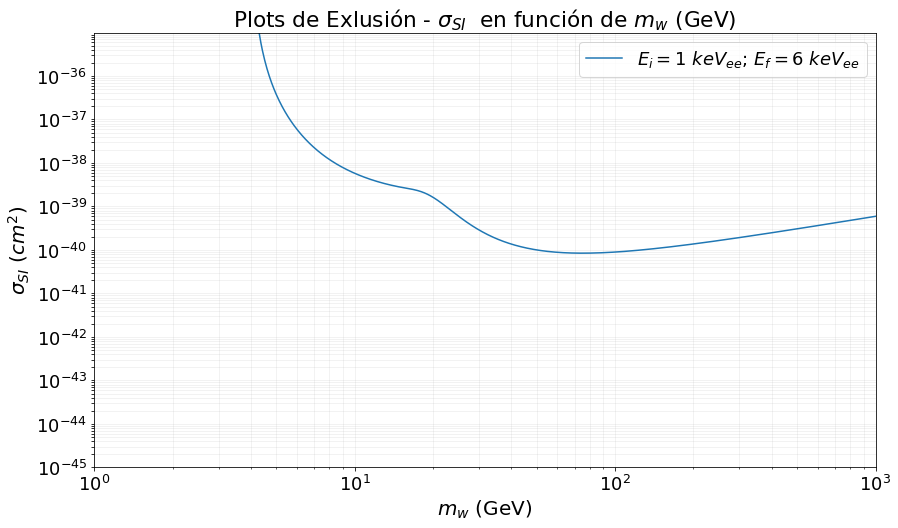

In [3]:

timeMax=72.9 
timeMin=255.5 
timeAvg=(timeMax+timeMin)/2.

mW_min=0.1 #masa wimp minima en GeV
mW_max=3

mWs=np.logspace(mW_min,mW_max,num=1000,endpoint=True)

#Calculamos función Numero de Cuentas teorico

Ei=1
Ef=6

sigmas=np.zeros(len(mWs))


for i in range (len(mWs)):
    sigmas[i]=calcula_sigma(Ei,Ef,mWs[i],timeAvg)
    



plt.figure(figsize=(14, 8))
ax = plt.subplot()

ax.plot(mWs,sigmas,label="$E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")


ax.legend()
ax.set_title(r'Plots de Exlusión - $\sigma_{SI}$  en función de $m_w$ (GeV)')
ax.set_ylabel(r'$\sigma_{SI}$ $(cm^2)$',fontsize=20)
ax.set_xlabel(r'$m_w$ (GeV)',fontsize=20)

ax.set_yscale("log")
ax.set_xscale("log")

y_sup=1e-35
y_inf=1e-45

ax.set_ylim(y_inf,y_sup)
ax.set_xlim(1,1000)

exp_min = int(np.floor(np.log10(y_inf)))   
exp_max = int(np.ceil(np.log10(y_sup)))    
exps = np.arange(exp_min, exp_max)     


all_ticks = []
for e in exps:
    decade = (np.arange(1, 10) * (10.0**e)).tolist()
    all_ticks.extend(decade)
all_ticks = np.array(all_ticks)

ax.set_yticks(all_ticks)                    

ax.grid(which='both', linestyle='-', alpha=0.2)

In [4]:
## LIBRERÍAS

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math
import uproot

## CONSTANTES GLOBALES

N_Avogadro=6.02214076*10**23
h_bar=6.582119569e-16
c=2.99792458e8
v_esc = 544 # km/s : Galactic Escape Speed
v_0 = 238 # km/s : Locad Standard of Rest Velocity
v_pec = np.array([11.1, 12.2, 7.3]) # km/s : Peculiar velocity of the Sun
v_sun = np.array([11.1, 12.2+v_0, 7.3]) # km/s : Sun velocity respect to the Galaxy
wimp_density = 0.3 # GeV/cm^3

## DEFINICIÓN DE FUNCIONES

def reduced_mass(m_N,m_WIMP):
    return m_N*m_WIMP/(m_N+m_WIMP) #GeV

def nucleus_mass(A):
    m_n = 0.9315 #GeV
    return A*m_n;

def detector_mass(A):
    return N_Avogadro/A*1000*nucleus_mass(A); #GeV/kg

def momento(m_N, E_R):
    # m_N in GeV
    # E_R in keV
    return np.sqrt(2*m_N*E_R/1000000); #GeV

def j1(x):
    return np.sin(x)/x**2-np.cos(x)/x; #dimensionless

def form_factor(A, E_R):
    m_N = nucleus_mass(A) #GeV
    q = momento (m_N, E_R) # GeV
    R = 1.2*A**(1./3.) #fm
    s = 1 #fm
    R1 = np.sqrt(R**2 - 5*s**2) #fm
    R1 = R1/(h_bar*c*10**(15))*10**9 #GeV^(-1)
    x = q*R1 #dimensionless
    if E_R==0:
        squared_form_factor = 1
    else:
        squared_form_factor = (3*j1(x)/x)**2 * np.exp(-(q**2)*(s/(h_bar*c*10**(15))*10**9)**2) #dimensionless
    return squared_form_factor;

def calculate_v_min(A, E_R, m_WIMP):
    m_N = nucleus_mass(A) # GeV
    mu = reduced_mass(m_N, m_WIMP) # GeV
    v_min = np.sqrt(m_N*E_R/1000000 / (2*mu**2)) # dimensionless
    return v_min

def calculate_v_earth(t):
    v_orb = 29.8 # km/s
    omega = 2*np.pi/365 # d^(-1)
    v_x = v_orb * (0.9941*np.cos(omega*t)-0.00504*np.sin(omega*t))
    v_y = v_orb * (0.1088*np.cos(omega*t)+0.4946*np.sin(omega*t))
    v_z = v_orb * (0.0042*np.cos(omega*t)-0.8677*np.sin(omega*t))
    v = np.array([v_x,v_y,v_z]) # [km/s, km/s, km/s]
    return v;

def eta(A, E_R, t, m_WIMP):
    v_min = calculate_v_min(A, E_R, m_WIMP) ## dimensionless
    v_earth = calculate_v_earth(t) ## [km/s, km/s, km/s]
    v_min = v_min * c/1000 ##km/s

    x = v_min / v_0
    y = np.linalg.norm(v_sun + v_earth) / v_0
    z = v_esc / v_0

    N = erf(z) - 2*z/np.sqrt(np.pi) * np.exp(-z**2)
    factor_comun = 1/(2*y*v_0) * 1/N
    if (0 <= x <= (z-y)):
        eta = factor_comun * ( erf(x+y) - erf(x-y) - (4/np.sqrt(np.pi))*y*np.exp(-z**2) )
    if ((z-y) < x <= (z+y)):
        eta = factor_comun * ( erf(z) - erf(x-y) - (2/np.sqrt(np.pi))*(z+y-x)*np.exp(-z**2) )
    if (x > (z+y)):
        eta = 0
    return eta;

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)
    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf
    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)
    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf
    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def dif_rate_ee(Eee,t,A,mW,sigmaSI, Q=1):
    E=Eee/Q # convert Eee to keV_NR
    mu = reduced_mass(0.9315, mW)
    factor_de_forma = form_factor(A, E)
    eta_val = eta(A, E, t, mW)
    dif_rate = detector_mass(A)*wimp_density/(2*mW*mu**2)*c**2/10*A**2*sigmaSI*factor_de_forma*eta_val/1E6*3600*2 ## cts/keV_NR/kg/d
    dif_rate/=Q
    return dif_rate ## cts/keVee/kg/d

def dif_rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
    rateNa = dif_rate_ee(Eee,t,23,mW,sigmaSI,QNa)
    rateI = dif_rate_ee(Eee,t,127,mW,sigmaSI,QI)
    return (rateNa*23.+rateI*127.)/(23.+127.)

def totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = getQFNa(energy_ee)
    qfI = getQFI(energy_ee)
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)])
    return rates.sum()*0.1

def totalRate_NaI_ee_DAMA(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = 0.3
    qfI = 0.09
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qfNa, qfI)
        for e in energy_ee])
    return rates.sum()*0.1

## N de cuentas = ritmo * exposición (m * t)
def numero_cuentas_teo(Eiee,Efee,t,mW,sigmaSI,det):
    retval=totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI)
    exposure=calculate_exposure(det)*12.5 ## kg*day
    retval*=exposure
    return retval

def calculate_exposure(det=0):  ## para el caso de ANAIS-112
    exposure=np.zeros(9)
    exposure[0]=2031.38*12.5
    exposure[1]=2033.20*12.5
    exposure[2]=2029.52*12.5
    exposure[3]=2022.55*12.5
    exposure[4]=2033.01*12.5
    exposure[5]=2030.18*12.5
    exposure[6]=2032.27*12.5 
    exposure[7]=2031.02*12.5
    exposure[8]=2020.29*12.5
    return exposure[det]

def experimental_total_rate_per_detector(energies, diff_rates, Ei=1.0, Ef=6.0):
    mask = (energies >= Ei) & (energies <= Ef)
    integral = np.sum(diff_rates[mask]) * 0.1 ## bineado de 0.1 keV en los histogramas
    return integral

def experimental_number_of_counts(det, energies, diff_rates, Ei=1.0, Ef=6.0):
    exposure = calculate_exposure(det)
    counts = exposure * experimental_total_rate_per_detector(energy_values[det], rate_values[det], Ei, Ef)
    return counts

def N_cuentas_exp(Ei, Ef, energies, rates):
    total_number_of_counts=0
    for i in range(9):
        total_number_of_counts += experimental_number_of_counts(i, energies[i], rates[i], Ei, Ef)
    return total_number_of_counts

file=uproot.open("Datos/BEhistos_year123456.root")

## cargo los histogramas dentro del archivo root (hay un histograma por detector)
hists=[file[f"hbea_123456y_D{i}"] for i in range(9)]

rate_values=[]
energy_values=[]

for i in range(9):
    ## al parecer esta función carga los bordes!! no el centro del bin. Lo corrijo abajo
    rates_per_det, edges_per_det = hists[i].to_numpy()
    energies_per_det = 0.5 * (edges_per_det[:-1] + edges_per_det[1:])
    rate_values.append(rates_per_det)
    energy_values.append(energies_per_det)

    ## ventanas en las que quiero calcular el plot de exclusión
E1_i, E1_f = 1.0, 6.0


Nexp1 = N_cuentas_exp(E1_i, E1_f, energy_values, rate_values)


secciones1 = []

masas=mWs
## delta (CL)
delta = 1.28 ## 90% CL

for mW in masas:
    
    nTeo1 = 0.0
   
    
    for det in range(9):
        nTeo1 += numero_cuentas_teo(E1_i, E1_f, timeAvg, mW, 1.0, det)
       
        
    sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1
  
    
    secciones1.append(sigma1)
 

/tmp/ipykernel_18292/668699428.py:221: RuntimeWarning: divide by zero encountered in double_scalars
  sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1


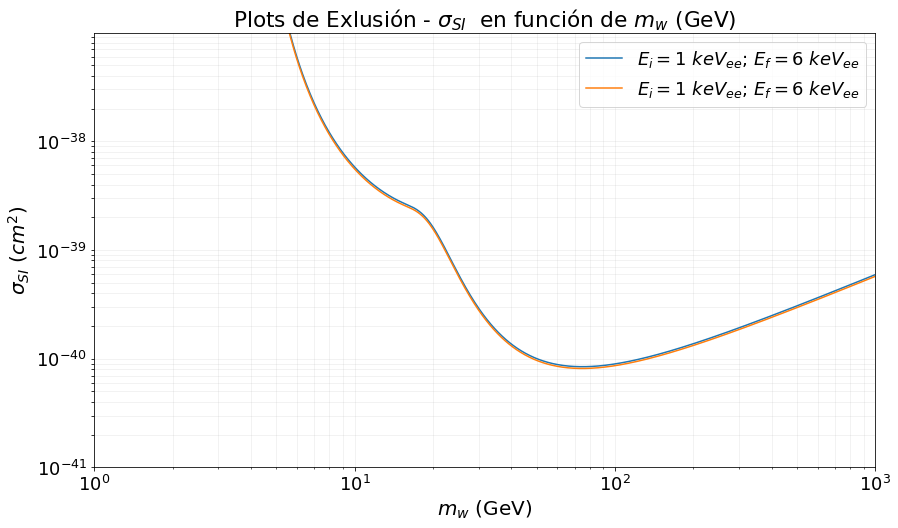

In [11]:
plt.figure(figsize=(14, 8))
ax = plt.subplot()

ax.plot(mWs,sigmas,label="$E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")
ax.plot(mWs,secciones1,label="$E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")


ax.legend()
ax.set_title(r'Plots de Exlusión - $\sigma_{SI}$  en función de $m_w$ (GeV)')
ax.set_ylabel(r'$\sigma_{SI}$ $(cm^2)$',fontsize=20)
ax.set_xlabel(r'$m_w$ (GeV)',fontsize=20)

ax.set_yscale("log")
ax.set_xscale("log")

y_sup=1e-37
y_inf=1e-41

ax.set_ylim(y_inf,y_sup)
ax.set_xlim(1,1000)

exp_min = int(np.floor(np.log10(y_inf)))   
exp_max = int(np.ceil(np.log10(y_sup)))    
exps = np.arange(exp_min, exp_max)     


all_ticks = []
for e in exps:
    decade = (np.arange(1, 10) * (10.0**e)).tolist()
    all_ticks.extend(decade)
all_ticks = np.array(all_ticks)

ax.set_yticks(all_ticks)                    

ax.grid(which='both', linestyle='-', alpha=0.2)

In [12]:
## LIBRERÍAS

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math
import uproot

## CONSTANTES GLOBALES

N_Avogadro=6.02214076*10**23
h_bar=6.582119569e-16
c=2.99792458e8
v_esc = 544 # km/s : Galactic Escape Speed
v_0 = 238 # km/s : Locad Standard of Rest Velocity
v_pec = np.array([11.1, 12.2, 7.3]) # km/s : Peculiar velocity of the Sun
v_sun = np.array([11.1, 12.2+v_0, 7.3]) # km/s : Sun velocity respect to the Galaxy
wimp_density = 0.3 # GeV/cm^3

## DEFINICIÓN DE FUNCIONES

def reduced_mass(m_N,m_WIMP):
    return m_N*m_WIMP/(m_N+m_WIMP) #GeV

def nucleus_mass(A):
    m_n = 0.9315 #GeV
    return A*m_n;

def detector_mass(A):
    return N_Avogadro/A*1000*nucleus_mass(A); #GeV/kg

def momento(m_N, E_R):
    # m_N in GeV
    # E_R in keV
    return np.sqrt(2*m_N*E_R/1000000); #GeV

def j1(x):
    return np.sin(x)/x**2-np.cos(x)/x; #dimensionless

def form_factor(A, E_R):
    m_N = nucleus_mass(A) #GeV
    q = momento (m_N, E_R) # GeV
    R = 1.2*A**(1./3.) #fm
    s = 1 #fm
    R1 = np.sqrt(R**2 - 5*s**2) #fm
    R1 = R1/(h_bar*c*10**(15))*10**9 #GeV^(-1)
    x = q*R1 #dimensionless
    if E_R==0:
        squared_form_factor = 1
    else:
        squared_form_factor = (3*j1(x)/x)**2 * np.exp(-(q**2)*(s/(h_bar*c*10**(15))*10**9)**2) #dimensionless
    return squared_form_factor;

def calculate_v_min(A, E_R, m_WIMP):
    m_N = nucleus_mass(A) # GeV
    mu = reduced_mass(m_N, m_WIMP) # GeV
    v_min = np.sqrt(m_N*E_R/1000000 / (2*mu**2)) # dimensionless
    return v_min

def calculate_v_earth(t):
    v_orb = 29.8 # km/s
    omega = 2*np.pi/365 # d^(-1)
    v_x = v_orb * (0.9941*np.cos(omega*t)-0.00504*np.sin(omega*t))
    v_y = v_orb * (0.1088*np.cos(omega*t)+0.4946*np.sin(omega*t))
    v_z = v_orb * (0.0042*np.cos(omega*t)-0.8677*np.sin(omega*t))
    v = np.array([v_x,v_y,v_z]) # [km/s, km/s, km/s]
    return v;

def eta(A, E_R, t, m_WIMP):
    v_min = calculate_v_min(A, E_R, m_WIMP) ## dimensionless
    v_earth = calculate_v_earth(t) ## [km/s, km/s, km/s]
    v_min = v_min * c/1000 ##km/s

    x = v_min / v_0
    y = np.linalg.norm(v_sun + v_earth) / v_0
    z = v_esc / v_0

    N = erf(z) - 2*z/np.sqrt(np.pi) * np.exp(-z**2)
    factor_comun = 1/(2*y*v_0) * 1/N
    if (0 <= x <= (z-y)):
        eta = factor_comun * ( erf(x+y) - erf(x-y) - (4/np.sqrt(np.pi))*y*np.exp(-z**2) )
    if ((z-y) < x <= (z+y)):
        eta = factor_comun * ( erf(z) - erf(x-y) - (2/np.sqrt(np.pi))*(z+y-x)*np.exp(-z**2) )
    if (x > (z+y)):
        eta = 0
    return eta;

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)
    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf
    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)
    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf
    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def dif_rate_ee(Eee,t,A,mW,sigmaSI, Q=1):
    E=Eee/Q # convert Eee to keV_NR
    mu = reduced_mass(0.9315, mW)
    factor_de_forma = form_factor(A, E)
    eta_val = eta(A, E, t, mW)
    dif_rate = detector_mass(A)*wimp_density/(2*mW*mu**2)*c**2/10*A**2*sigmaSI*factor_de_forma*eta_val/1E6*3600*24 ## cts/keV_NR/kg/d
    dif_rate/=Q
    return dif_rate ## cts/keVee/kg/d

def dif_rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
    rateNa = dif_rate_ee(Eee,t,23,mW,sigmaSI,QNa)
    rateI = dif_rate_ee(Eee,t,127,mW,sigmaSI,QI)
    return (rateNa*23.+rateI*127.)/(23.+127.)

def totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = getQFNa(energy_ee)
    qfI = getQFI(energy_ee)
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)])
    return rates.sum()*0.1

def totalRate_NaI_ee_DAMA(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = 0.3
    qfI = 0.09
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qfNa, qfI)
        for e in energy_ee])
    return rates.sum()*0.1

## N de cuentas = ritmo * exposición (m * t)
def numero_cuentas_teo(Eiee,Efee,t,mW,sigmaSI,det):
    retval=totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI)
    exposure=calculate_exposure(det)*12.5 ## kg*day
    retval*=exposure
    return retval

def calculate_exposure(det=0):  ## para el caso de ANAIS-112
    exposure=np.zeros(9)
    exposure[0]=2031.38*12.5
    exposure[1]=2033.20*12.5
    exposure[2]=2029.52*12.5
    exposure[3]=2022.55*12.5
    exposure[4]=2033.01*12.5
    exposure[5]=2030.18*12.5
    exposure[6]=2032.27*12.5 
    exposure[7]=2031.02*12.5
    exposure[8]=2020.29*12.5
    return exposure[det]

def experimental_total_rate_per_detector(energies, diff_rates, Ei=1.0, Ef=6.0):
    mask = (energies >= Ei) & (energies <= Ef)
    integral = np.sum(diff_rates[mask]) * 0.1 ## bineado de 0.1 keV en los histogramas
    return integral

def experimental_number_of_counts(det, energies, diff_rates, Ei=1.0, Ef=6.0):
    exposure = calculate_exposure(det)
    counts = exposure * experimental_total_rate_per_detector(energy_values[det], rate_values[det], Ei, Ef)
    return counts

def N_cuentas_exp(Ei, Ef, energies, rates):
    total_number_of_counts=0
    for i in range(9):
        total_number_of_counts += experimental_number_of_counts(i, energies[i], rates[i], Ei, Ef)
    return total_number_of_counts

file=uproot.open("Datos/BEhistos_year123456.root")

## cargo los histogramas dentro del archivo root (hay un histograma por detector)
hists=[file[f"hbea_123456y_D{i}"] for i in range(9)]

rate_values=[]
energy_values=[]

for i in range(9):
    ## al parecer esta función carga los bordes!! no el centro del bin. Lo corrijo abajo
    rates_per_det, edges_per_det = hists[i].to_numpy()
    energies_per_det = 0.5 * (edges_per_det[:-1] + edges_per_det[1:])
    rate_values.append(rates_per_det)
    energy_values.append(energies_per_det)

    ## ventanas en las que quiero calcular el plot de exclusión
E1_i, E1_f = 1.0, 6.0


Nexp1 = N_cuentas_exp(E1_i, E1_f, energy_values, rate_values)


secciones1 = []

masas=mWs
## delta (CL)
delta = 1.28 ## 90% CL

for mW in masas:
    
    nTeo1 = 0.0
   
    
    for det in range(9):
        nTeo1 += numero_cuentas_teo(E1_i, E1_f, timeAvg, mW, 1.0, det)
       
        
    sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1
  
    
    secciones1.append(sigma1)
 

/tmp/ipykernel_18292/904467649.py:221: RuntimeWarning: divide by zero encountered in double_scalars
  sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1


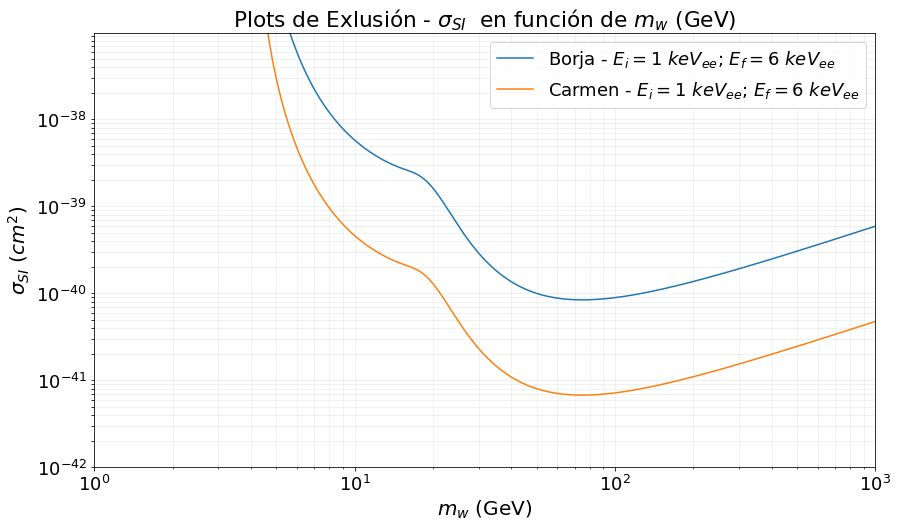

In [15]:
plt.figure(figsize=(14, 8))
ax = plt.subplot()

ax.plot(mWs,sigmas,label="Borja - $E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")
ax.plot(mWs,secciones1,label="Carmen - $E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")


ax.legend()
ax.set_title(r'Plots de Exlusión - $\sigma_{SI}$  en función de $m_w$ (GeV)')
ax.set_ylabel(r'$\sigma_{SI}$ $(cm^2)$',fontsize=20)
ax.set_xlabel(r'$m_w$ (GeV)',fontsize=20)

ax.set_yscale("log")
ax.set_xscale("log")

y_sup=1e-37
y_inf=1e-42

ax.set_ylim(y_inf,y_sup)
ax.set_xlim(1,1000)

exp_min = int(np.floor(np.log10(y_inf)))   
exp_max = int(np.ceil(np.log10(y_sup)))    
exps = np.arange(exp_min, exp_max)     


all_ticks = []
for e in exps:
    decade = (np.arange(1, 10) * (10.0**e)).tolist()
    all_ticks.extend(decade)
all_ticks = np.array(all_ticks)

ax.set_yticks(all_ticks)                    

ax.grid(which='both', linestyle='-', alpha=0.2)

In [16]:
## LIBRERÍAS

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math
import uproot

## CONSTANTES GLOBALES

N_Avogadro=6.02214076*10**23
h_bar=6.582119569e-16
c=2.99792458e8
v_esc = 544 # km/s : Galactic Escape Speed
v_0 = 238 # km/s : Locad Standard of Rest Velocity
v_pec = np.array([11.1, 12.2, 7.3]) # km/s : Peculiar velocity of the Sun
v_sun = np.array([11.1, 12.2+v_0, 7.3]) # km/s : Sun velocity respect to the Galaxy
wimp_density = 0.3 # GeV/cm^3

## DEFINICIÓN DE FUNCIONES

def reduced_mass(m_N,m_WIMP):
    return m_N*m_WIMP/(m_N+m_WIMP) #GeV

def nucleus_mass(A):
    m_n = 0.9315 #GeV
    return A*m_n;

def detector_mass(A):
    return N_Avogadro/A*1000*nucleus_mass(A); #GeV/kg

def momento(m_N, E_R):
    # m_N in GeV
    # E_R in keV
    return np.sqrt(2*m_N*E_R/1000000); #GeV

def j1(x):
    return np.sin(x)/x**2-np.cos(x)/x; #dimensionless

def form_factor(A, E_R):
    m_N = nucleus_mass(A) #GeV
    q = momento (m_N, E_R) # GeV
    R = 1.2*A**(1./3.) #fm
    s = 1 #fm
    R1 = np.sqrt(R**2 - 5*s**2) #fm
    R1 = R1/(h_bar*c*10**(15))*10**9 #GeV^(-1)
    x = q*R1 #dimensionless
    if E_R==0:
        squared_form_factor = 1
    else:
        squared_form_factor = (3*j1(x)/x)**2 * np.exp(-(q**2)*(s/(h_bar*c*10**(15))*10**9)**2) #dimensionless
    return squared_form_factor;

def calculate_v_min(A, E_R, m_WIMP):
    m_N = nucleus_mass(A) # GeV
    mu = reduced_mass(m_N, m_WIMP) # GeV
    v_min = np.sqrt(m_N*E_R/1000000 / (2*mu**2)) # dimensionless
    return v_min

def calculate_v_earth(t):
    v_orb = 29.8 # km/s
    omega = 2*np.pi/365 # d^(-1)
    v_x = v_orb * (0.9941*np.cos(omega*t)-0.00504*np.sin(omega*t))
    v_y = v_orb * (0.1088*np.cos(omega*t)+0.4946*np.sin(omega*t))
    v_z = v_orb * (0.0042*np.cos(omega*t)-0.8677*np.sin(omega*t))
    v = np.array([v_x,v_y,v_z]) # [km/s, km/s, km/s]
    return v;

def eta(A, E_R, t, m_WIMP):
    v_min = calculate_v_min(A, E_R, m_WIMP) ## dimensionless
    v_earth = calculate_v_earth(t) ## [km/s, km/s, km/s]
    v_min = v_min * c/1000 ##km/s

    x = v_min / v_0
    y = np.linalg.norm(v_sun + v_earth) / v_0
    z = v_esc / v_0

    N = erf(z) - 2*z/np.sqrt(np.pi) * np.exp(-z**2)
    factor_comun = 1/(2*y*v_0) * 1/N
    if (0 <= x <= (z-y)):
        eta = factor_comun * ( erf(x+y) - erf(x-y) - (4/np.sqrt(np.pi))*y*np.exp(-z**2) )
    if ((z-y) < x <= (z+y)):
        eta = factor_comun * ( erf(z) - erf(x-y) - (2/np.sqrt(np.pi))*(z+y-x)*np.exp(-z**2) )
    if (x > (z+y)):
        eta = 0
    return eta;

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)
    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf
    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)
    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf
    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def dif_rate_ee(Eee,t,A,mW,sigmaSI, Q=1):
    E=Eee/Q # convert Eee to keV_NR
    mu = reduced_mass(0.9315, mW)
    factor_de_forma = form_factor(A, E)
    eta_val = eta(A, E, t, mW)
    dif_rate = detector_mass(A)*wimp_density/(2*mW*mu**2)*c**2/10*A**2*sigmaSI*factor_de_forma*eta_val/1E6*3600*24 ## cts/keV_NR/kg/d
    dif_rate/=Q
    return dif_rate ## cts/keVee/kg/d

def dif_rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
    rateNa = dif_rate_ee(Eee,t,23,mW,sigmaSI,QNa)
    rateI = dif_rate_ee(Eee,t,127,mW,sigmaSI,QI)
    return (rateNa*23.+rateI*127.)/(23.+127.)

def totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = getQFNa(energy_ee)
    qfI = getQFI(energy_ee)
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)])
    return rates.sum()*0.1

def totalRate_NaI_ee_DAMA(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = 0.3
    qfI = 0.09
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qfNa, qfI)
        for e in energy_ee])
    return rates.sum()*0.1

## N de cuentas = ritmo * exposición (m * t)
def numero_cuentas_teo(Eiee,Efee,t,mW,sigmaSI,det):
    retval=totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI)
    exposure=calculate_exposure(det) ## kg*day
    retval*=exposure
    return retval

def calculate_exposure(det=0):  ## para el caso de ANAIS-112
    exposure=np.zeros(9)
    exposure[0]=2031.38*12.5
    exposure[1]=2033.20*12.5
    exposure[2]=2029.52*12.5
    exposure[3]=2022.55*12.5
    exposure[4]=2033.01*12.5
    exposure[5]=2030.18*12.5
    exposure[6]=2032.27*12.5 
    exposure[7]=2031.02*12.5
    exposure[8]=2020.29*12.5
    return exposure[det]

def experimental_total_rate_per_detector(energies, diff_rates, Ei=1.0, Ef=6.0):
    mask = (energies >= Ei) & (energies <= Ef)
    integral = np.sum(diff_rates[mask]) * 0.1 ## bineado de 0.1 keV en los histogramas
    return integral

def experimental_number_of_counts(det, energies, diff_rates, Ei=1.0, Ef=6.0):
    exposure = calculate_exposure(det)
    counts = exposure * experimental_total_rate_per_detector(energy_values[det], rate_values[det], Ei, Ef)
    return counts

def N_cuentas_exp(Ei, Ef, energies, rates):
    total_number_of_counts=0
    for i in range(9):
        total_number_of_counts += experimental_number_of_counts(i, energies[i], rates[i], Ei, Ef)
    return total_number_of_counts

file=uproot.open("Datos/BEhistos_year123456.root")

## cargo los histogramas dentro del archivo root (hay un histograma por detector)
hists=[file[f"hbea_123456y_D{i}"] for i in range(9)]

rate_values=[]
energy_values=[]

for i in range(9):
    ## al parecer esta función carga los bordes!! no el centro del bin. Lo corrijo abajo
    rates_per_det, edges_per_det = hists[i].to_numpy()
    energies_per_det = 0.5 * (edges_per_det[:-1] + edges_per_det[1:])
    rate_values.append(rates_per_det)
    energy_values.append(energies_per_det)

    ## ventanas en las que quiero calcular el plot de exclusión
E1_i, E1_f = 1.0, 6.0


Nexp1 = N_cuentas_exp(E1_i, E1_f, energy_values, rate_values)


secciones1 = []

masas=mWs
## delta (CL)
delta = 1.28 ## 90% CL

for mW in masas:
    
    nTeo1 = 0.0
   
    
    for det in range(9):
        nTeo1 += numero_cuentas_teo(E1_i, E1_f, timeAvg, mW, 1.0, det)
       
        
    sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1
  
    
    secciones1.append(sigma1)
 

/tmp/ipykernel_18292/1134886362.py:221: RuntimeWarning: divide by zero encountered in double_scalars
  sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1


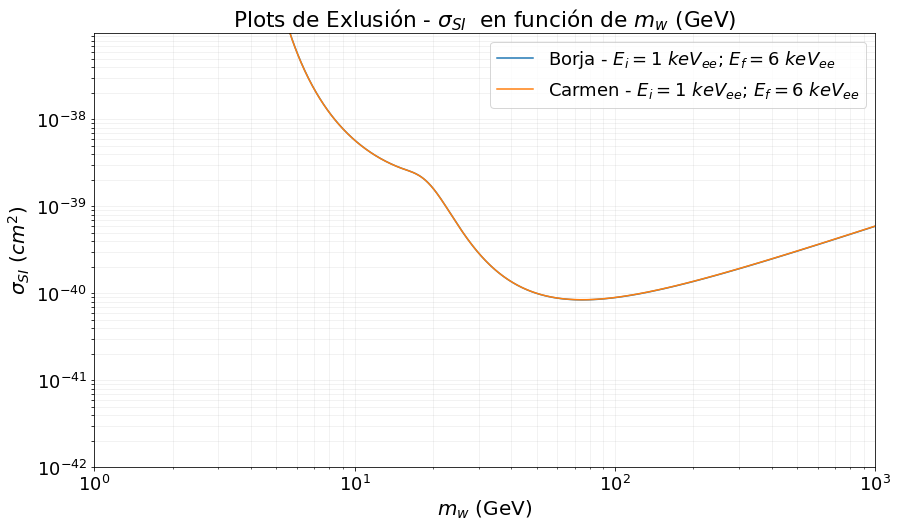

In [17]:
plt.figure(figsize=(14, 8))
ax = plt.subplot()

ax.plot(mWs,sigmas,label="Borja - $E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")
ax.plot(mWs,secciones1,label="Carmen - $E_i=$"+f"{Ei}"+" $keV_{ee}$; $E_f=$"+f"{Ef}"+" $keV_{ee}$")


ax.legend()
ax.set_title(r'Plots de Exlusión - $\sigma_{SI}$  en función de $m_w$ (GeV)')
ax.set_ylabel(r'$\sigma_{SI}$ $(cm^2)$',fontsize=20)
ax.set_xlabel(r'$m_w$ (GeV)',fontsize=20)

ax.set_yscale("log")
ax.set_xscale("log")

y_sup=1e-37
y_inf=1e-42

ax.set_ylim(y_inf,y_sup)
ax.set_xlim(1,1000)

exp_min = int(np.floor(np.log10(y_inf)))   
exp_max = int(np.ceil(np.log10(y_sup)))    
exps = np.arange(exp_min, exp_max)     


all_ticks = []
for e in exps:
    decade = (np.arange(1, 10) * (10.0**e)).tolist()
    all_ticks.extend(decade)
all_ticks = np.array(all_ticks)

ax.set_yticks(all_ticks)                    

ax.grid(which='both', linestyle='-', alpha=0.2)